# Pump it Up

*Please note that we expect
to see a comparison of multiple approaches to solving the issue from different partners in the team.*

Competition Link Here

amount_tsh - Total static head (amount water available to waterpoint): the amount of water the pump can push or provide, measured in height (meters). It's a way to gauge the water capacity or pressure the pump can handle or is dealing with.
date_recorded - The date the row was entered
funder - Who funded the well
gps_height - Altitude of the well
installer - Organization that installed the well
longitude - GPS coordinate
latitude - GPS coordinate
wpt_name - Name of the waterpoint if there is one
num_private -
basin - Geographic water basin
subvillage - Geographic location
region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)
lga - Geographic location
ward - Geographic location
population - Population around the well
public_meeting - True/False, whether a public meeting about this water pump has taken place?
recorded_by - Group entering this row of data
scheme_management - Who operates the waterpoint
scheme_name - Who operates the waterpoint
permit - If the waterpoint is permitted
construction_year - Year the waterpoint was constructed
extraction_type - The kind of extraction the waterpoint uses
extraction_type_group - The kind of extraction the waterpoint uses
extraction_type_class - The kind of extraction the waterpoint uses
management - How the waterpoint is managed
management_group - How the waterpoint is managed
payment - What the water costs
payment_type - What the water costs
water_quality - The quality of the water
quality_group - The quality of the water
quantity - The quantity of water
quantity_group - The quantity of water
source - The source of the water
source_type - The source of the water
source_class - The source of the water
waterpoint_type - The kind of waterpoint
waterpoint_type_group - The kind of waterpoint

Imputation Progress

## Import Data & Data Cleaning

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator
!pip install autoimpute 


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Adding Data

In [47]:
#Reading Datasets
training_values = pd.read_csv('training_set_values.csv')

#Reading Dataset of pumps
training_labels = pd.read_csv('training_set_labels.csv')

#Reading Final test Values
test_values = pd.read_csv('test_set_values.csv')

all_df = pd.concat([training_values, test_values])
 

#Inner Merging these two datasets
training = pd.merge(training_values, training_labels, on='id', how='inner') 
training.rename(columns={'status_group': 'functional'}, inplace=True)

import sklearn
from sklearn.model_selection import train_test_split

X = training.drop(columns=['functional'])
y = training['functional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
random_state=1, stratify=y)



coursework_progress = coursework_progress = pd.DataFrame({
    'Column Names': training.columns.tolist(), 
    "Taken Care Of": False, 
    "Imputation Techniques Tried": [[] for _ in training.columns],  
    "Imputation Technique Used": [None for _ in training.columns] 
})
imputed_df = pd.DataFrame()

def log_imputation(column_name: str, technique: str, final: bool):
    index = coursework_progress['Column Names'].tolist().index(column_name)
    coursework_progress.at[index, "Imputation Techniques Tried"].append(technique)
    if final:
        coursework_progress.at[index, "Taken Care Of"] = True
        coursework_progress.at[index, "Imputation Technique Used"] = technique


In [48]:
#Helper function
def check_impute_difference (feature, original_dataset, current_dataframe):
  original_dataset[feature].plot(kind='kde', )
  current_dataframe[feature].plot(kind='kde', style = "--")
  labels = ['Original Dataset', 'Current Dataframe']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.show()

## Sorting out Null Values

Many columns have rows who's values are null, but that Pandas does not recognise as these are not properly labelled (0 population for example is likely a NaN value)

In [49]:
#Globally replace NaN strings

dataframes = [X_train, X_test, test_values, all_df]

for df in dataframes:

    df.replace(inplace=True, to_replace='nan', value=np.nan)
    df.replace(inplace=True, to_replace='NaN', value=np.nan)
    df.replace(inplace=True, to_replace='NAN', value=np.nan)
    df.replace(inplace=True, to_replace='nAn', value=np.nan)
    df.replace(inplace=True, to_replace='Nan', value=np.nan)
    df.replace(inplace=True, to_replace='naN', value=np.nan)

    df['amount_tsh'].replace(inplace=True, to_replace=0, value=np.nan)
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['gps_height'].replace(0, np.nan, inplace=True)
    df['longitude'].replace(0, np.nan, inplace=True)
    df['latitude'].replace(0, np.nan, inplace=True)
    df['population'].replace(0, np.nan, inplace=True)
    df['construction_year'].replace(0, np.nan, inplace=True)




/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/2025291455.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['amount_tsh'].replace(inplace=True, to_replace=0, value=np.nan)
/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/2025291455.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

### Missing Data Analysis

The percentage of missing data varies from 0.6% to 98.7%


In [50]:
missing = round((all_df.isna().sum())/len(all_df)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

amount_tsh           70.1
scheme_name          48.6
population           36.1
construction_year    35.0
gps_height           34.5
scheme_management     6.5
funder                6.1
installer             6.1
public_meeting        5.6
permit                5.1
longitude             3.1
subvillage            0.6
payment_type          0.0
management_group      0.0
payment               0.0
dtype: float64

There is a clear relation between missing values in gps_height, population, construction_year and to some degree longitude. i.e. data is not missing at random.

In [51]:
import missingno as msno

<Axes: >

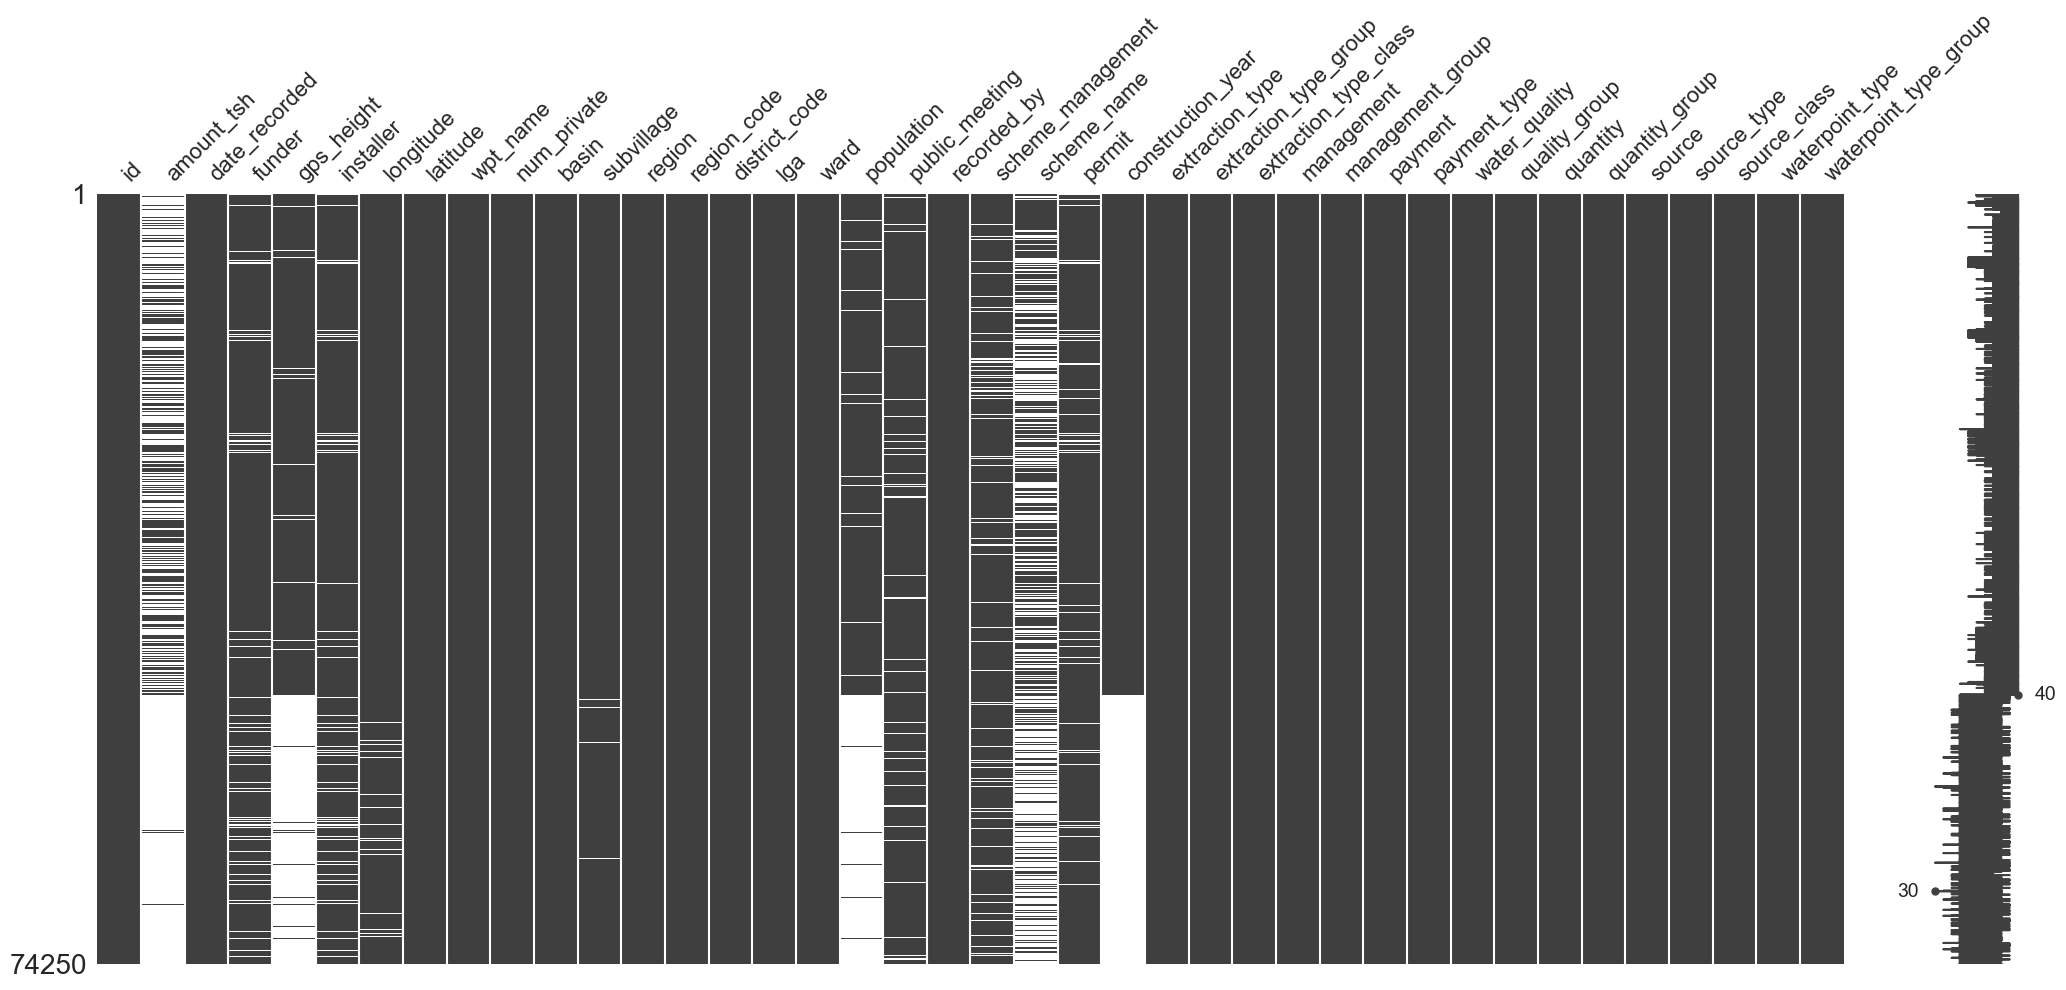

In [52]:
sorted = all_df.sort_values('construction_year')
msno.matrix(sorted)

Strong correlation in missingness

<Axes: >

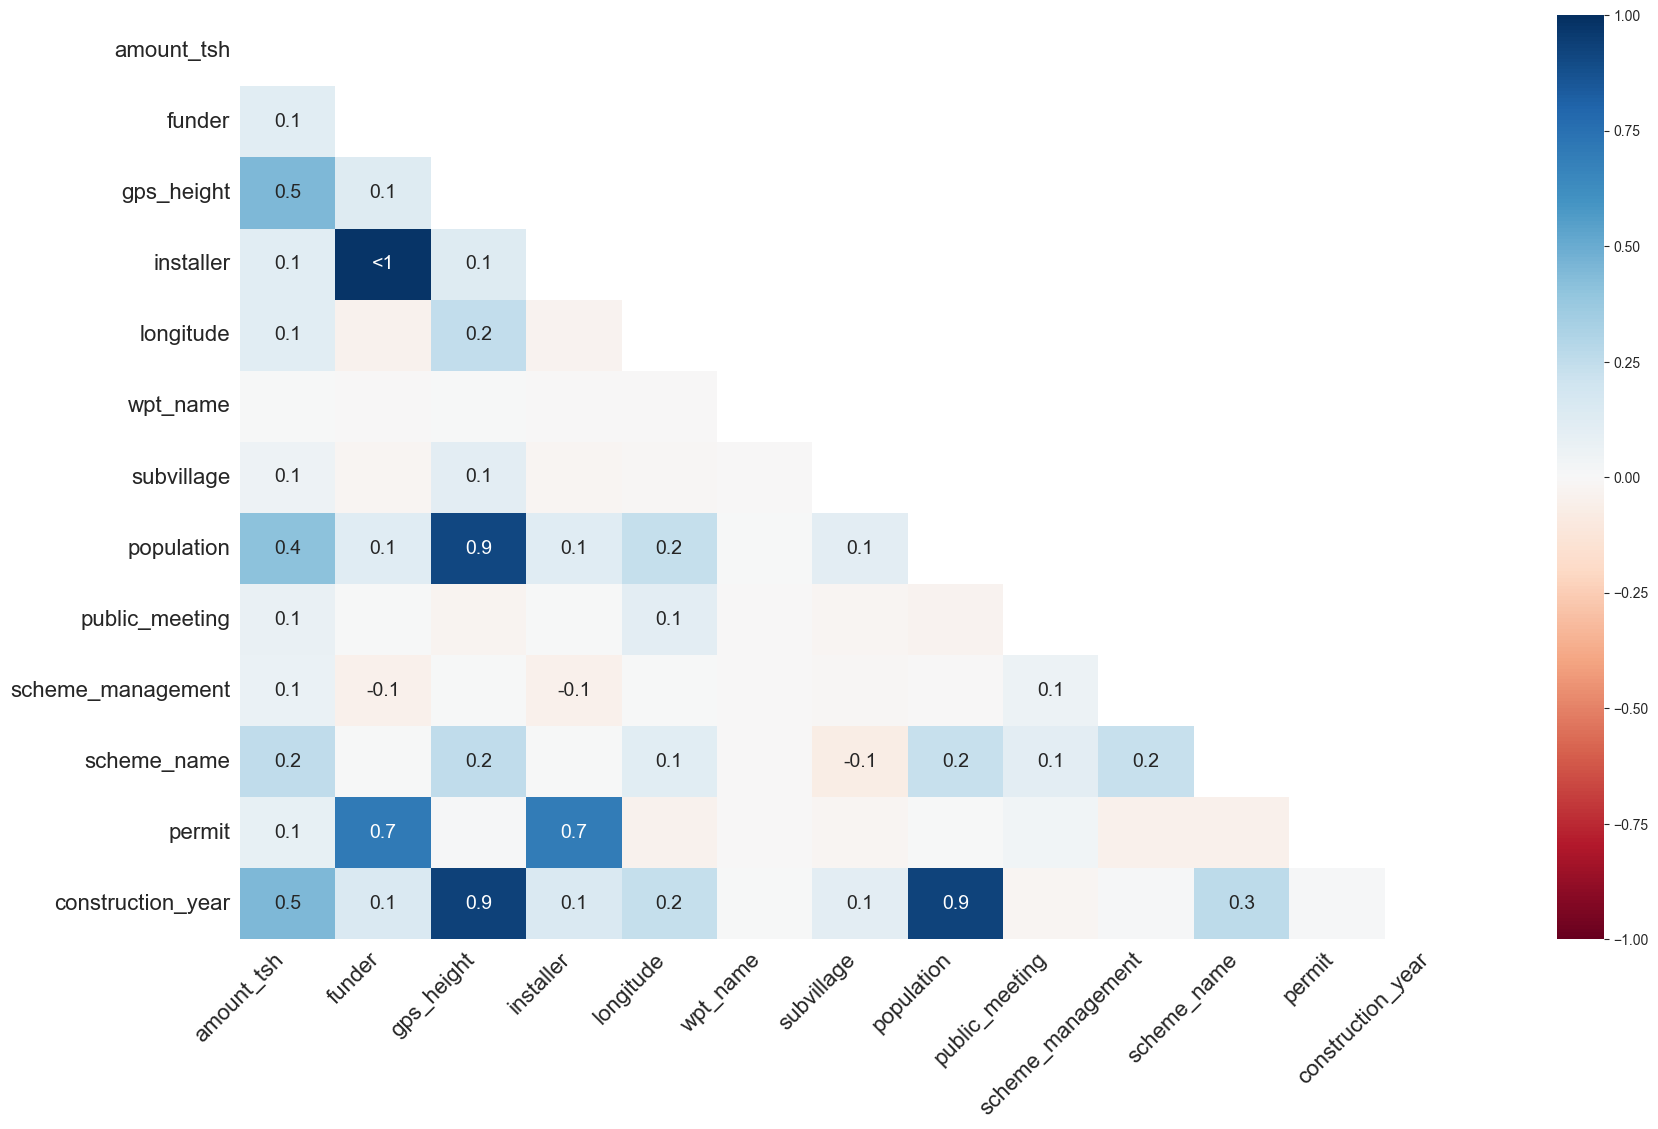

In [53]:
msno.heatmap(all_df)

In [54]:
all_df[all_df['gps_height'] < all_df['gps_height'].quantile(0.05)]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34,41583,NaN,2011-02-23,NaN,-41.0,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,...,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
137,64062,30.0,2013-01-25,Lips,11.0,LIPS,39.888981,-10.133632,Bondeni 1,0,...,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
145,28669,50.0,2013-03-21,0,12.0,0,39.185710,-6.892593,Chekanao,0,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
148,53167,NaN,2013-01-24,Fini Water,1.0,Fini water,39.600234,-10.027721,Kwa Timba,0,...,unknown,salty,salty,enough,enough,machine dbh,borehole,groundwater,other,other
152,60983,NaN,2013-03-16,0,-15.0,0,39.527114,-6.988748,Msikitini,0,...,never pay,salty,salty,dry,dry,machine dbh,borehole,groundwater,other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14755,2811,NaN,2011-03-20,Islamic Found,-11.0,Is,38.900477,-6.446184,Mwembeyanga,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14767,64526,NaN,2013-01-24,Serikali Ya Kijiji,7.0,Serikali ya kijiji,39.592783,-10.024897,Kwa Choka,0,...,unknown,soft,good,enough,enough,spring,spring,groundwater,other,other
14811,14638,100.0,2011-03-26,Private Individual,-26.0,Da,39.091240,-6.577881,Kapalila,0,...,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14817,33339,10.0,2011-03-05,W.B,-31.0,DWE,39.188873,-7.888840,Mng'Ombe,0,...,per bucket,salty,salty,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump


### Tsh Values (amount water available to waterpoint)

In [55]:
#Proportion of rows with an amount of tsh_value = np.nan
number_of_zeros = all_df['amount_tsh'].isnull().sum().sum()
print(number_of_zeros / len(df.index) * 100)

70.09966329966329


70% of TSH values are missing. It could be a useful feature as it is essentially a representation of the power of a pump. Higher Power Pumps could indicate that it receives more maintenance as it is more "important", as shown below. The "mega pumps" > 120_000 are all functional.

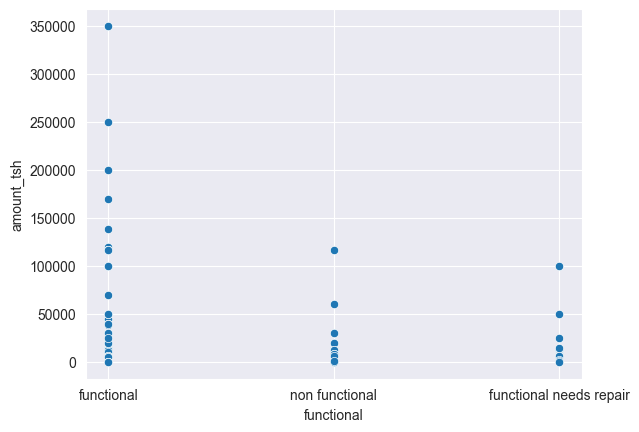

In [56]:
sns.scatterplot(training, x='functional', y='amount_tsh')
plt.show()

However, seeing as the majority of the values are missing, for now we are going to remove it as imputation of such a scale would be risky and could confuse the model.

In [57]:
log_imputation('amount_tsh', 'removal', final=True)
for df in dataframes:
    df.drop(columns=['amount_tsh'], inplace=True)

### Num Private 

The num_private value has no description, and most of the values are zero. So we decide to drop it

In [58]:
all_df['num_private']

0        0
1        0
2        0
3        0
4        0
        ..
14845    0
14846    0
14847    0
14848    0
14849    0
Name: num_private, Length: 74250, dtype: int64

In [59]:
for df in dataframes:
    df.drop(columns=['num_private'], inplace=True, axis=1)
log_imputation('num_private', "removal", final=True)

### Water Quality and Quality Group

Identified different spellings of "coloured" and "colored"

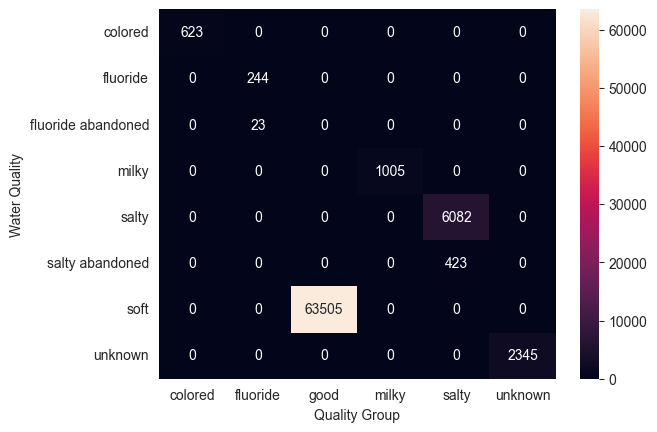

In [60]:
for df in dataframes:
    df.replace(inplace=True, to_replace="coloured", value="colored")

contingency_table = pd.crosstab(all_df['water_quality'], all_df['quality_group'])
sns.heatmap(contingency_table, annot=True, fmt="d")
plt.xlabel('Quality Group')
plt.ylabel('Water Quality')
plt.show()

This shows that the water_quality and water_group columns are essentially identical, but it uses a choice of different words. It seems reasonable to drop one of these two columns. Therefore we could merge these two columns by keeping the Quality group and appending the idea of 'soft' water to 'good' water

In [61]:
for df in dataframes:
    df['water_quality'].replace(to_replace='soft', value='soft (good)', inplace=True)
    df.drop(axis=1, columns=['quality_group'], inplace=True)
log_imputation('quality_group', 'removal', True)

/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/879519960.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['water_quality'].replace(to_replace='soft', value='soft (good)', inplace=True)
/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/879519960.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

### Quantity and Quantity_Group

In [62]:
all_df["quantity_columns_same"] = all_df["quantity"] == all_df["quantity_group"]
print((all_df['quantity_columns_same'] == True).sum())
print((all_df['quantity_columns_same'] == False).sum())

74250
0


We have shown that these two columns are identical, so it is safe to drop one of them, quantity_group is more descriptive so we are keeping the latter. Quantity is dropped.

In [63]:
for df in dataframes:
    df.drop(columns=['quantity'], inplace=True)
log_imputation('quantity', 'removal', True)

### Waterpoint_type and Waterpoint_type_group

In [64]:
all_df["waterpoint_type_same"] = all_df["waterpoint_type"] == all_df["waterpoint_type_group"]
print((all_df['waterpoint_type_same'] == True).sum())
print((all_df['waterpoint_type_same'] == False).sum())

66639
7611


In [65]:
all_df[all_df["waterpoint_type_same"] == False]

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,payment_type,water_quality,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,quantity_columns_same,waterpoint_type_same
2,34310,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329e+00,Kwa Mahundi,Pangani,Majengo,...,per bucket,soft (good),enough,dam,dam,surface,communal standpipe multiple,communal standpipe,True,False
3,67743,2013-01-28,Unicef,263.0,UNICEF,38.486161,-1.115530e+01,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,...,never pay,soft (good),dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,True,False
5,9944,2011-03-13,Mkinga Distric Coun,NaN,DWE,39.172796,-4.765587e+00,Tajiri,Pangani,Moa/Mwereme,...,per bucket,salty,enough,other,other,unknown,communal standpipe multiple,communal standpipe,True,False
53,32376,2011-08-01,Government Of Tanzania,NaN,Government,NaN,-2.000000e-08,Polisi,Lake Victoria,Center,...,unknown,unknown,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,True,False
55,68724,2013-02-22,Muwsa,766.0,MUWSA,37.348169,-3.356538e+00,Environment,Pangani,Dhobi Street,...,per bucket,soft (good),insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14762,6867,2013-02-24,Cdtf,1342.0,DWE,35.284436,-9.815460e+00,Kwa Festo,Lake Nyasa,Muhande,...,on failure,soft (good),enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,True,False
14765,64665,2013-02-11,World Bank,1260.0,DWE,35.830211,-4.130413e+00,Bomba La Shuleni,Internal,Gubali,...,per bucket,soft (good),enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe,True,False
14766,56279,2012-11-04,Government Of Tanzania,NaN,RWE,NaN,-2.000000e-08,Ofisini,Lake Victoria,Madukani,...,never pay,soft (good),insufficient,lake,river/lake,surface,communal standpipe multiple,communal standpipe,True,False
14773,35480,2011-04-11,Water,NaN,Commu,35.886779,-6.064549e+00,Zahanati,Wami / Ruvu,Sokoine,...,never pay,soft (good),dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,True,False


We have shown that waterpoint_type and waterpoint_type_group overlap, the only exception is certain waterpoint_type columns also have the suffix "multiple". Therefore it seems reasonsable to decide to remove the column "waterpoint_type_group" for now. Removing excessive columns helps prevent against overfitting as is better for performance and manageability of the data.

In [66]:
for df in dataframes:
    df.drop(columns=['waterpoint_type_group'], inplace=True)
log_imputation('waterpoint_type_group', 'removal', True)

### Payment and Payment_type

Payment and Payment Type might be similar, so we are checking their differences

In [67]:
all_df["payment_same"] = all_df["payment"] == all_df["payment_type"]
print((all_df['payment_same'] == True).sum())
print((all_df['payment_same'] == False).sum())

43175
31075


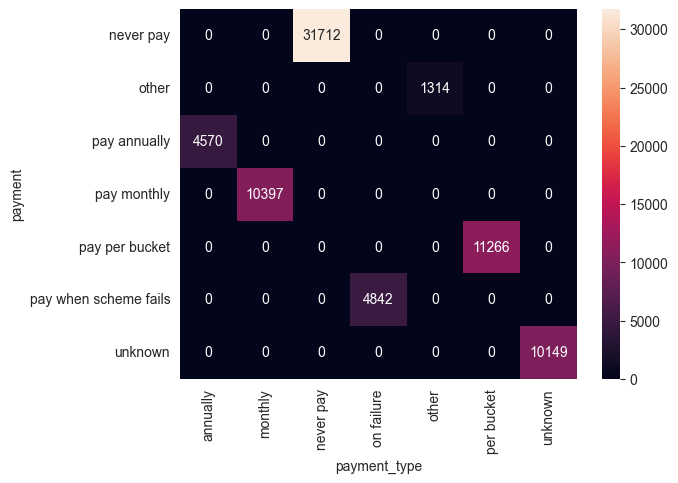

In [68]:
contingency_table = pd.crosstab(all_df['payment'], all_df['payment_type'])
sns.heatmap(contingency_table, annot=True, fmt="d")
plt.show()

The Heatmap shows that these two columns are the same but with different wording, we are choosing to keep the payment_type as the wording is a bit more concise

In [69]:
all_df[all_df["payment_same"] == False]

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,payment_type,water_quality,quantity_group,source,source_type,source_class,waterpoint_type,quantity_columns_same,waterpoint_type_same,payment_same
0,69572,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,...,annually,soft (good),enough,spring,spring,groundwater,communal standpipe,True,True,False
2,34310,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,...,per bucket,soft (good),enough,dam,dam,surface,communal standpipe multiple,True,False,False
5,9944,2011-03-13,Mkinga Distric Coun,NaN,DWE,39.172796,-4.765587,Tajiri,Pangani,Moa/Mwereme,...,per bucket,salty,enough,other,other,unknown,communal standpipe multiple,True,False,False
11,50409,2013-02-18,Danida,1062.0,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,Lake Nyasa,Ngondombwito,...,on failure,soft (good),insufficient,shallow well,shallow well,groundwater,hand pump,True,True,False
13,50495,2013-03-15,Lawatefuka Water Supply,1368.0,Lawatefuka water sup,37.092574,-3.181783,Kwa John Izack Mmari,Pangani,Omarini,...,monthly,soft (good),enough,spring,spring,groundwater,communal standpipe,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14834,12592,2011-03-27,Kirde,NaN,DWE,35.840727,-4.633272,Kwa Mrangi,Internal,Cheke,...,monthly,soft (good),insufficient,spring,spring,groundwater,communal standpipe,True,True,False
14837,71252,2013-02-10,Tasaf,1241.0,TASAF,30.114667,-4.162845,Pentecoste Church,Lake Tanganyika,Minazi,...,annually,soft (good),enough,machine dbh,borehole,groundwater,hand pump,True,True,False
14838,7869,2011-03-11,Kkkt,2046.0,Commu,34.345525,-9.547077,none,Lake Nyasa,Kipengele,...,annually,soft (good),enough,spring,spring,groundwater,communal standpipe,True,True,False
14842,57731,2013-01-27,Isf,808.0,DWE,29.740224,-4.882705,Hongera,Lake Tanganyika,Mzizini A,...,monthly,soft (good),enough,river,river/lake,surface,communal standpipe multiple,True,False,False


In [70]:
for df in dataframes:
    df.drop(columns=['payment'], inplace=True, axis=1)
log_imputation('payment', 'removal', True)

### Funder, Installer and Permit

The funder column is a bit problematic as it has a few inconsistencies: 0s to repalces NaN, as well as "No" which we assumes means there is no funder to report. We will be imputing the installer at this stage as well, as it shows a high correlation in missing values.

We are also removing trailing spaces for good measure in case to minimise unique values

In [71]:
for df in dataframes:
    print("Number of Unique Funders before: ", len(df['funder'].unique()))
    df['funder'].replace(inplace=True, to_replace='0', value=np.nan) #Few Values of 0
    df['funder'].replace(inplace=True, to_replace='No', value=np.nan) #Few values of 'no'
    df['funder'] = df['funder'].str.strip() #Strip trailing spaces
    print("Number of Unique Funders after: ", len(df['funder'].unique()))


Number of Unique Funders before:  1559
Number of Unique Funders after:  1557
Number of Unique Funders before:  1071
Number of Unique Funders after:  1069
Number of Unique Funders before:  980
Number of Unique Funders after:  978
Number of Unique Funders before:  2140
Number of Unique Funders after:  2138


/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/2533374763.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['funder'].replace(inplace=True, to_replace='0', value=np.nan) #Few Values of 0
/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/2533374763.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

As funder is a category, we will first try mode imputation

Percentage of null values funder:  0.07592592592592592
Percentage of null values installer:  0.06120731120731121
Percentage of null values permit:  0.05117845117845118
Mode:  Government Of Tanzania


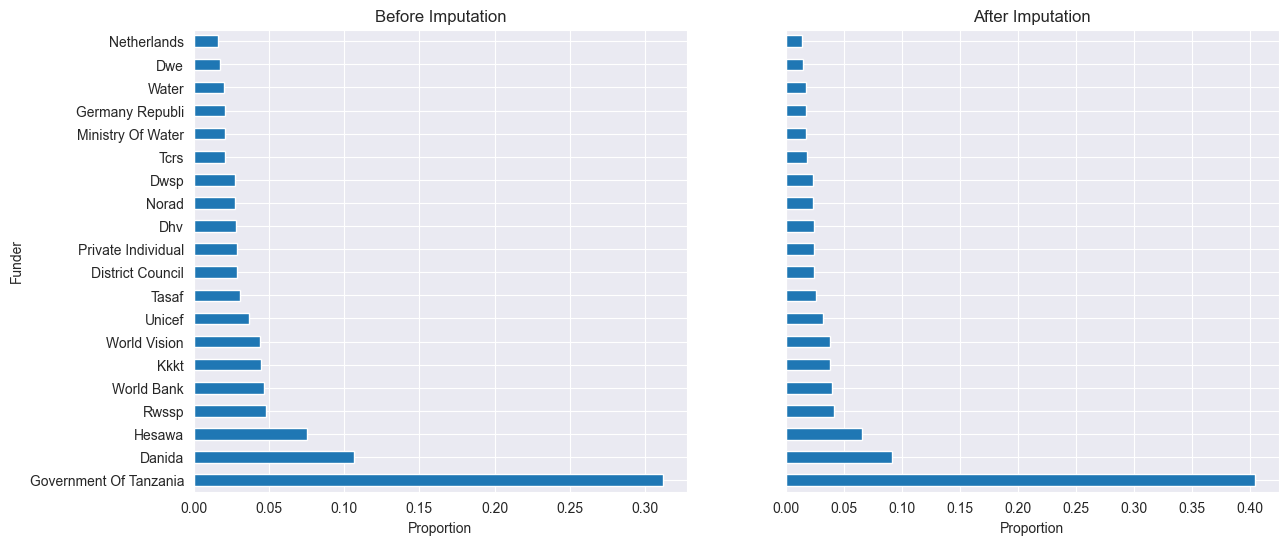

In [72]:
df_train_funder = X_train.copy()
df_test_funder = X_test.copy()
df_test_values_funder = test_values.copy()

print("Percentage of null values funder: ", df_train_funder['funder'].isnull().mean())
print("Percentage of null values installer: ", df_train_funder['installer'].isnull().mean())
print("Percentage of null values permit: ", df_train_funder['permit'].isnull().mean())


mode_value = df_train_funder['funder'].mode()[0]  
print("Mode: ", mode_value)

# Correct way to replace NaN values with the mode
df_train_funder['funder'] = df_train_funder['funder'].fillna(mode_value)

# Selecting top funders from the original dataset for comparison
top_funders = X_train['funder'].value_counts().nlargest(20).index

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
X_train[X_train['funder'].isin(top_funders)]['funder'].value_counts(normalize=True).plot(kind='barh', ax=ax[0], title='Before Imputation')
df_train_funder[df_train_funder['funder'].isin(top_funders)]['funder'].value_counts(normalize=True).plot(kind='barh', ax=ax[1], title='After Imputation')

ax[0].set_xlabel('Proportion')
ax[0].set_ylabel('Funder')
ax[1].set_xlabel('Proportion')
plt.show()

Essentially, we are assuming that the 6% of missing funders are the Governemnt fo Tanzania, this doesn't feel very accurate and coud lead to issues. Therefore, we are going to be replacing missing values with a "missing" category; this will make the model create a missing category. This feels safer than simply making all the missing categories part of the "Government of Tanzania"

In [73]:
for df in dataframes:
    df['funder'].replace(np.nan, 'missing', inplace=True)
    df['installer'].replace(np.nan, 'missing', inplace=True)
    df['permit'].replace(np.nan, 'missing', inplace=True)

log_imputation('funder', 'missing category', final=True)
log_imputation('installer', 'missing category', final=True)
log_imputation('permit', 'missing category', final=True)

/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/15143054.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['funder'].replace(np.nan, 'missing', inplace=True)
/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/15143054.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

### Subvillage

Subvillage is missing around 0.7% 

### Scheme Management

Percentage of null values in scheme management: 6.53%


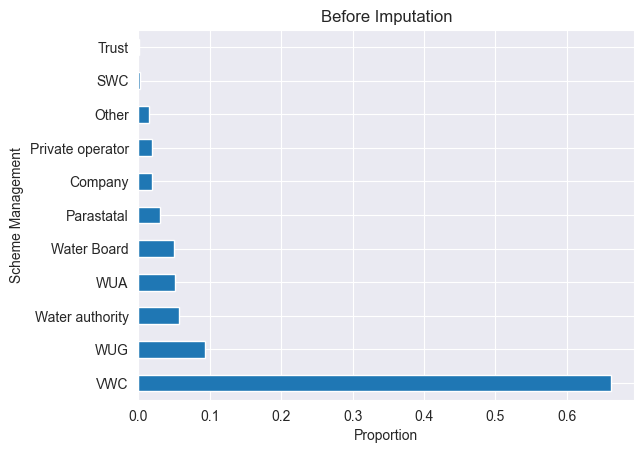

In [74]:
df_scheme = all_df.copy()

null_percentage = df_scheme['scheme_management'].isnull().mean() * 100

print("Percentage of null values in scheme management: {:.2f}%".format(null_percentage))

# Finding the top 20 'scheme_management' categories
top_schemes = df_scheme['scheme_management'].value_counts().nlargest(20).index

# Creating a figure and axes for plotting
fig, ax = plt.subplots()

# Plotting the distribution of 'scheme_management' for the top categories
df_scheme[df_scheme['scheme_management'].isin(top_schemes)]['scheme_management'].value_counts(normalize=True).plot(kind='barh', title='Before Imputation', ax=ax)

ax.set_xlabel('Proportion')
ax.set_ylabel('Scheme Management')
plt.show()

As we can see, over 60% of the values of the values of scheme_management are 'VWC'; missing data analysis from earlier reveals that this column does not have any missingness correlation with any other column; it is safe to assume therefore that it is MAR. Therefore, we will choose to impute the value with the most column value: VWC

In [75]:
mode_value = df_scheme['scheme_management'].mode()[0]  
print("Mode of Scheme Management: ", mode_value)

# Correct way to replace NaN values with the mode
for df in dataframes:
    df['scheme_management'] = df['scheme_management'].fillna(mode_value)

Mode of Scheme Management:  VWC


### Public Meeting

The public meeting column does not have any correlation with any other column. It is difficult to impute as it is a binary column which seems to have a specific meeting, and so we are going to make the decision of removing this column

In [76]:
for df in dataframes:
    df.drop(columns=['public_meeting'], inplace=True)
log_imputation('public_meeting', 'removal', final=True)

### Scheme Name

In [77]:
print("Empty scheme names: ", (all_df['scheme_name'].isnull()).sum())
print("One letter scheme names: ", all_df[all_df['scheme_name'].str.len() == 1].shape[0])


Empty scheme names:  36052
One letter scheme names:  2629


Looking through the column, we can see that almost half of all values are empty, and many values seem to be incomplete or inconsistent. Therefore, we are going to drop this column

In [78]:
for df in dataframes:
    df.drop(columns=['scheme_name'], inplace=True)
log_imputation('scheme_name', "removal", final=True)

## Location (Gps_height, Longitude, Latitude)

In [79]:



print("Longitude: ", (all_df['longitude'].isnull()).sum())
print("Latitude: ", (all_df['latitude'].isnull()).sum()) 
print((all_df['gps_height'].isnull()).sum())

Longitude:  2269
Latitude:  0
25649


Looking at the latitude and longitude

Latitude Null values are shown as `-2e-8` so we are replacing them by np.nan

In [80]:
all_df[all_df['longitude'].isnull()] 

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,payment_type,water_quality,quantity_group,source,source_type,source_class,waterpoint_type,quantity_columns_same,waterpoint_type_same,payment_same
21,6091,2013-02-10,Dwsp,NaN,DWE,NaN,-2.000000e-08,Muungano,Lake Victoria,Ibabachegu,...,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,True,True,True
53,32376,2011-08-01,Government Of Tanzania,NaN,Government,NaN,-2.000000e-08,Polisi,Lake Victoria,Center,...,unknown,unknown,dry,machine dbh,borehole,groundwater,communal standpipe multiple,True,False,True
168,72678,2013-01-30,Wvt,NaN,WVT,NaN,-2.000000e-08,Wvt Tanzania,Lake Victoria,Ilula,...,other,soft (good),seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,True,True,True
177,56725,2013-01-17,Netherlands,NaN,DWE,NaN,-2.000000e-08,Kikundi Cha Wakina Mama,Lake Victoria,Mahaha,...,unknown,soft (good),enough,shallow well,shallow well,groundwater,other,True,True,True
253,13042,2012-10-29,Hesawa,NaN,DWE,NaN,-2.000000e-08,Kwakisusi,Lake Victoria,Nyamatala,...,never pay,soft (good),insufficient,shallow well,shallow well,groundwater,hand pump,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14649,30454,2011-08-08,Nyamigogo,NaN,MASWI,NaN,-2.000000e-08,Husein,Lake Victoria,Nyaweshi,...,never pay,soft (good),insufficient,shallow well,shallow well,groundwater,hand pump,True,True,True
14676,44766,2013-02-16,Dwsp,NaN,DWE,NaN,-2.000000e-08,Imalanota,Lake Victoria,Busumabwi,...,other,soft (good),enough,shallow well,shallow well,groundwater,hand pump,True,True,True
14766,56279,2012-11-04,Government Of Tanzania,NaN,RWE,NaN,-2.000000e-08,Ofisini,Lake Victoria,Madukani,...,never pay,soft (good),insufficient,lake,river/lake,surface,communal standpipe multiple,True,False,True
14831,37994,2012-10-26,Hesawa,NaN,DWE,NaN,-2.000000e-08,Kwa Masilili,Lake Victoria,Solima A,...,never pay,salty,enough,shallow well,shallow well,groundwater,hand pump,True,True,True


In [81]:
for df in dataframes:
    df['latitude'].replace(-2e-8, np.nan, inplace=True)

/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/3817145585.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['latitude'].replace(-2e-8, np.nan, inplace=True)


In [82]:
loc_df = training.copy() #Creating a copy of training dataframe to try out imputation performance

In [83]:
print("Longitude: ", (loc_df['longitude'].isnull()).sum())
print("Latitude: ", (loc_df['latitude'].isnull()).sum()) 
print((loc_df['gps_height'].isnull()).sum())

Longitude:  0
Latitude:  0
0


Many of the water (1/3) pump have a GPS_height of 0. We could use a Maps API to estimate the gps_height based on the longitude and latitude of the water pump such as https://www.dcode.fr/earth-elevation

However, this would be expensive as there are a huge amount of values. Therefore, we are going to calculate the mean gps_height of similary located water pumps of the same: subvillage, region, lga, ward. Inspired by: "Hwang, Sungsoon & Webber-Ritchey, Kashica & Moxley, Elizabeth. (2022). Comparison of GPS imputation methods in environmental health research. Geospatial Health. 17. 10.4081/gh.2022.1081. "

In [84]:
mean_gps_height = loc_df.groupby(['subvillage', 'region', 'lga', 'ward'])['gps_height'].mean().reset_index(name='mean_gps_height')
mean_longitude = loc_df.groupby([ 'subvillage', 'region', 'lga', 'ward'])['longitude'].mean().reset_index(name='mean_longitude')
mean_latitude = loc_df.groupby(['subvillage', 'region', 'lga', 'ward'])['latitude'].mean().reset_index(name='mean_latitude')


loc_df = loc_df.merge(mean_gps_height, on=['subvillage', 'region', 'lga', 'ward'], how='left')
loc_df = loc_df.merge(mean_longitude, on=['subvillage', 'region', 'lga', 'ward'], how='left')
loc_df = loc_df.merge(mean_latitude, on=['subvillage', 'region', 'lga', 'ward'], how='left')

loc_df.loc[loc_df['gps_height'].isnull(), 'gps_height'] = loc_df['mean_gps_height']
loc_df.loc[loc_df['longitude'].isnull(), 'longitude'] = loc_df['mean_longitude']
loc_df.loc[loc_df['latitude'].isnull(), 'latitude'] = loc_df['mean_latitude']

loc_df.drop(columns=['mean_gps_height', 'mean_longitude', 'mean_latitude'], inplace=True)

Longitude:  0
Latitude:  0
0


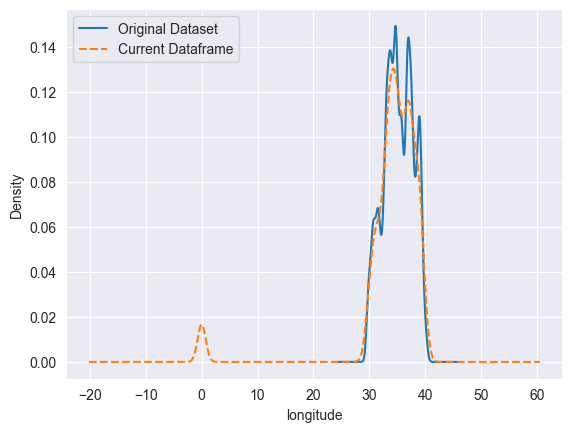

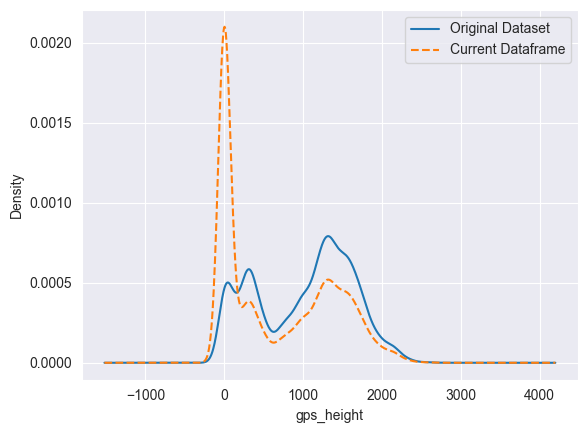

In [85]:
print("Longitude: ", (loc_df['longitude'].isnull()).sum())
print("Latitude: ", (loc_df['latitude'].isnull()).sum()) 
print((loc_df['gps_height'].isnull()).sum())
check_impute_difference('longitude', X_train, loc_df)
check_impute_difference('gps_height', X_train, loc_df)

So far, this has not been very useful as it has only imputed about 100 values of heights, and about 20 on longitude and latitude. Therefore, we will try doing a less granular approach for this imputation, but following the same idea: subvillage < ward < lga < region

### Ward

Longitude:  0
Latitude:  0
0


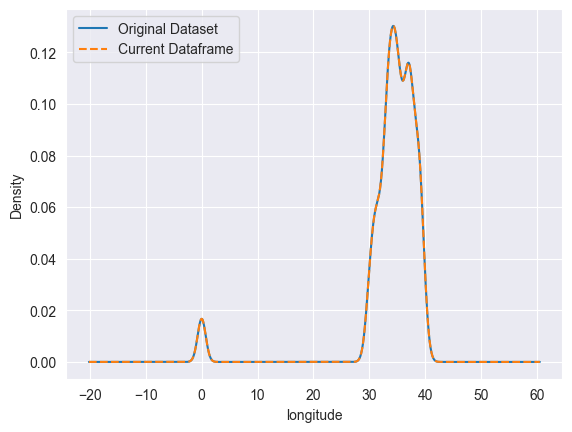

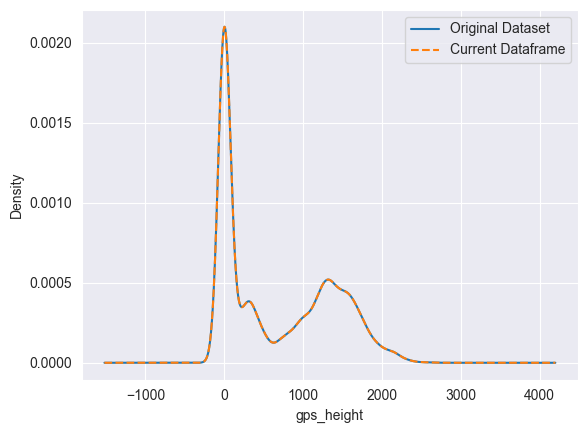

In [86]:
mean_gps_height = loc_df.groupby(['region', 'lga', 'ward'])['gps_height'].mean().reset_index(name='mean_gps_height')
mean_longitude = loc_df.groupby(['region', 'lga', 'ward'])['longitude'].mean().reset_index(name='mean_longitude')
mean_latitude = loc_df.groupby(['region', 'lga', 'ward'])['latitude'].mean().reset_index(name='mean_latitude')


loc_df = loc_df.merge(mean_gps_height, on=['region', 'lga', 'ward'], how='left')
loc_df = loc_df.merge(mean_longitude, on=['region', 'lga', 'ward'], how='left')
loc_df = loc_df.merge(mean_latitude, on=['region', 'lga', 'ward'], how='left')

loc_df.loc[training['gps_height'].isnull(), 'gps_height'] = loc_df['mean_gps_height']
loc_df.loc[training['longitude'].isnull(), 'longitude'] = loc_df['mean_longitude']
loc_df.loc[training['latitude'].isnull(), 'latitude'] = loc_df['mean_latitude']

loc_df.drop(columns=['mean_gps_height', 'mean_longitude', 'mean_latitude'], inplace=True)
print("Longitude: ", (loc_df['longitude'].isnull()).sum())
print("Latitude: ", (loc_df['latitude'].isnull()).sum()) 
print((loc_df['gps_height'].isnull()).sum())
check_impute_difference('longitude', training, loc_df)
check_impute_difference('gps_height', training, loc_df)

### Local Government Area

Longitude:  0
Latitude:  0
0


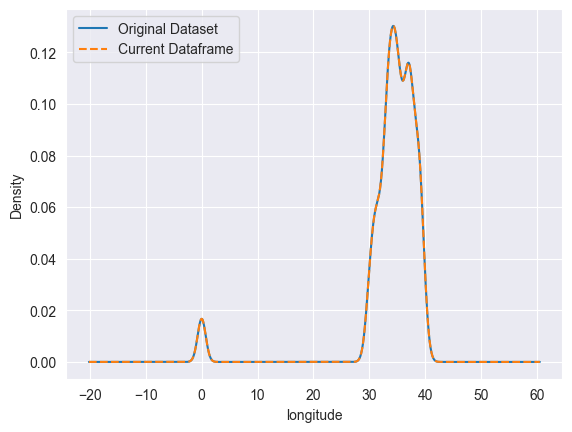

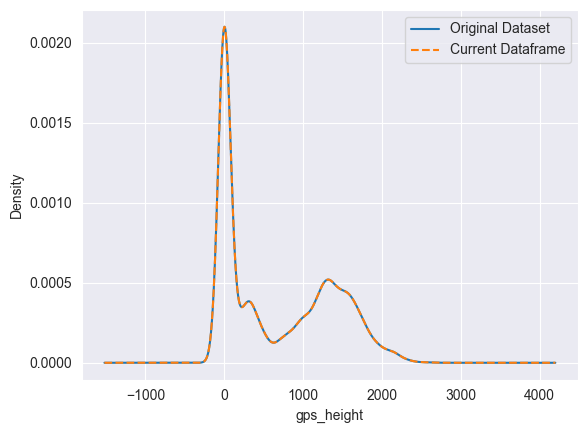

In [87]:
mean_gps_height = loc_df.groupby(['region', 'lga'])['gps_height'].mean().reset_index(name='mean_gps_height')
mean_longitude = loc_df.groupby(['region', 'lga'])['longitude'].mean().reset_index(name='mean_longitude')
mean_latitude = loc_df.groupby(['region', 'lga'])['latitude'].mean().reset_index(name='mean_latitude')


loc_df = loc_df.merge(mean_gps_height, on=['region', 'lga'], how='left')
loc_df = loc_df.merge(mean_longitude, on=['region', 'lga'], how='left')
loc_df = loc_df.merge(mean_latitude, on=['region', 'lga'], how='left')

loc_df.loc[training['gps_height'].isnull(), 'gps_height'] = loc_df['mean_gps_height']
loc_df.loc[training['longitude'].isnull(), 'longitude'] = loc_df['mean_longitude']
loc_df.loc[training['latitude'].isnull(), 'latitude'] = loc_df['mean_latitude']

loc_df.drop(columns=['mean_gps_height', 'mean_longitude', 'mean_latitude'], inplace=True)
print("Longitude: ", (loc_df['longitude'].isnull()).sum())
print("Latitude: ", (loc_df['latitude'].isnull()).sum()) 
print((loc_df['gps_height'].isnull()).sum())
check_impute_difference('longitude', training, loc_df)
check_impute_difference('gps_height', training, loc_df)

### Region

Longitude:  0
Latitude:  0
0


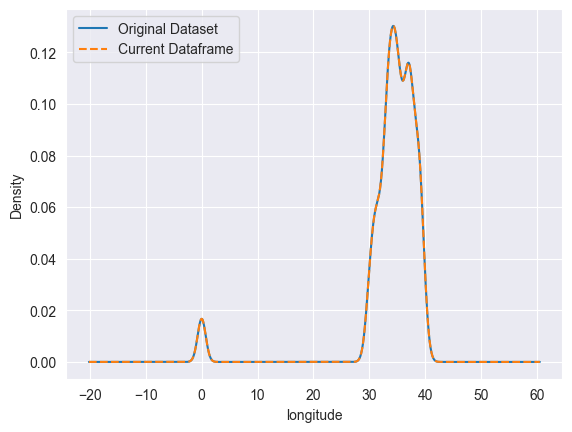

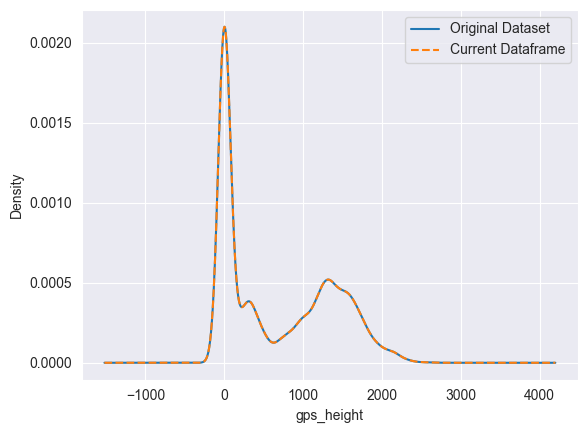

In [88]:
mean_gps_height = loc_df.groupby(['region'])['gps_height'].mean().reset_index(name='mean_gps_height')
mean_longitude = loc_df.groupby(['region'])['longitude'].mean().reset_index(name='mean_longitude')
mean_latitude = loc_df.groupby(['region'])['latitude'].mean().reset_index(name='mean_latitude')


loc_df = loc_df.merge(mean_gps_height, on=['region'], how='left')
loc_df = loc_df.merge(mean_longitude, on=['region'], how='left')
loc_df = loc_df.merge(mean_latitude, on=['region'], how='left')

df.loc[training['gps_height'].isnull(), 'gps_height'] = loc_df['mean_gps_height']
df.loc[training['longitude'].isnull(), 'longitude'] = loc_df['mean_longitude']
df.loc[training['latitude'].isnull(), 'latitude'] = loc_df['mean_latitude']

loc_df.drop(columns=['mean_gps_height', 'mean_longitude', 'mean_latitude'], inplace=True)
print("Longitude: ", (loc_df['longitude'].isnull()).sum())
print("Latitude: ", (loc_df['latitude'].isnull()).sum()) 
print((loc_df['gps_height'].isnull()).sum())
check_impute_difference('longitude', training, loc_df)
check_impute_difference('gps_height', training, loc_df)

/var/folders/5c/ddcnr00d7mqg7z9wsy9drjfh0000gn/T/ipykernel_49611/1989620350.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '668.297239057239' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  loc_df.loc[loc_df['gps_height'].isnull(), 'gps_height'] = mean_gps_height


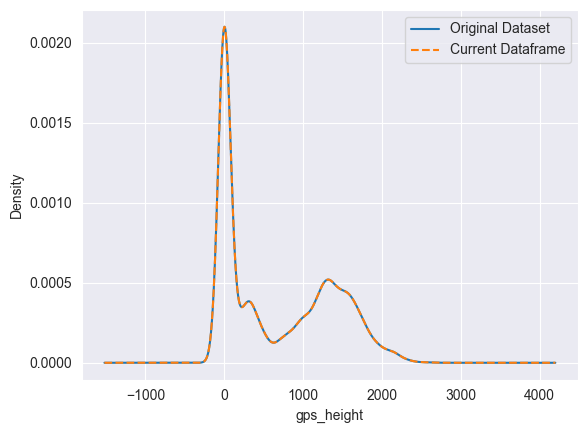

In [89]:
mean_gps_height = training['gps_height'].mean()

loc_df.loc[loc_df['gps_height'].isnull(), 'gps_height'] = mean_gps_height

check_impute_difference('gps_height', training, loc_df)
log_imputation('gps_height', 'mean', final=False)
log_imputation('longitude', 'mean', final=False)
log_imputation('latitude', 'mean', final=False)

We have successfully imputed all values of longitude and latitude missing values. However, this last step of replacing all remaining values has completely changed the distribution of the data, which is not very optimal.

Another common technique of imputation is using Multiple Imputation by Chained Equations (MICE). Essentially, it imputes the data by going through a series of prediction regression models, creating several imputed datasets and combining the optimal output. (source)

 We will be using autoimpute, which is a library that helps us use common imputation techniques on our data.

In [90]:
df_train_mice = X_train.copy()
df_test_mice = X_test.copy()
df_test_values_mice = test_values.copy()


df_train_mice.drop(columns=['installer',  'subvillage', 'lga', 'ward', 'wpt_name', 'date_recorded', 'district_code', 'funder', 'permit'], inplace=True)
df_test_mice.drop(columns=['installer',  'subvillage', 'lga', 'ward', 'wpt_name', 'date_recorded', 'district_code', 'funder', 'permit'], inplace=True)
df_test_values_mice.drop(columns=['installer',  'subvillage', 'lga', 'ward', 'wpt_name', 'date_recorded', 'district_code', 'funder', 'permit'], inplace=True)

categories = [cname for cname in df_train_mice.columns if
                    df_train_mice[cname].dtype == "object"]




from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

for col in categories:
  encoder = LabelEncoder()
  df_train_mice[col] = encoder.fit_transform(df_train_mice[col])
  df_test_mice[col] = encoder.transform(df_test_mice[col])
  df_test_values_mice[col] = encoder.transform(df_test_values_mice[col])

imputer = IterativeImputer()

df_train_mice.iloc[:, :] = imputer.fit_transform(df_train_mice)
df_test_mice.iloc[:, :] = imputer.transform(df_test_mice)
df_test_values_mice.iloc[:, :] = imputer.transform(df_test_values_mice)


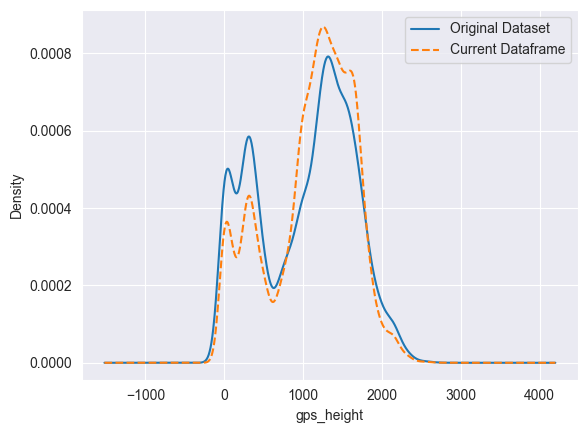

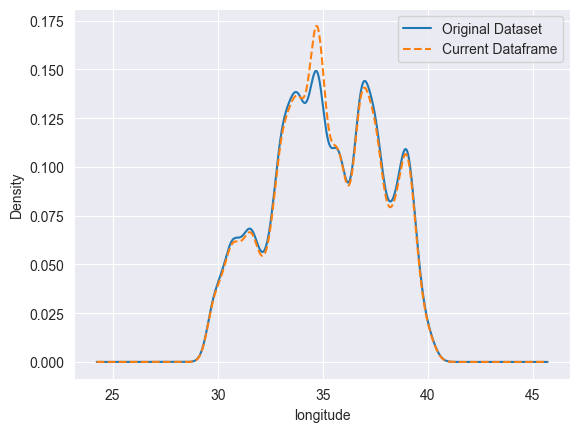

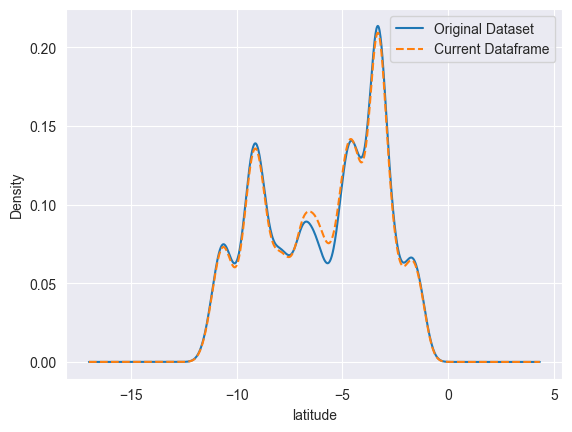

In [91]:

check_impute_difference('gps_height', X_train, df_train_mice)
check_impute_difference('longitude', X_train, df_train_mice)
check_impute_difference('latitude', X_train, df_train_mice)

This imputation technique has brought about better results than Mean imputation, therefore, we will choose to use the MICE imputation.

In [92]:

log_imputation('gps_height', 'mice', final=True)
log_imputation('longitude', 'mice', final=True)
log_imputation('latitude', 'mice', final=True)


X_train['gps_height'] = df_train_mice['gps_height']
X_train['longitude'] = df_train_mice['longitude']
X_train['latitude'] = df_train_mice['latitude']


X_test['gps_height'] = df_test_mice['gps_height']
X_test['longitude'] = df_test_mice['longitude']
X_test['latitude'] = df_test_mice['latitude']

test_values['gps_height'] = df_test_values_mice['gps_height']
test_values['longitude'] = df_test_values_mice['longitude']
test_values['latitude'] = df_test_values_mice['latitude']


<hr>

### Population

Due to the nature of the Population column, the same imputation techniques that we used on the location could be trialed; it is a integer and has a high importance to do the dataset. We are going to assume that a population value of zero is null, because a water pump would usually be installed in an area with a population.

In [93]:
print("Number of null Populations: ", df['population'].isnull().sum())

Number of null Populations:  26834


In [94]:
pop_df = X_train.copy()

Logically, it would make sense that populations would be similar or identical in similar areas, therefore we are going to get the mean of the missing population values based on Geographical Locations as we did above for GPS information

In [95]:
#Subvillage
mean_population = pop_df.groupby(['subvillage', 'region', 'lga', 'ward'])['population'].mean().reset_index(name='mean_population')
pop_df = pop_df.merge(mean_population, on=['subvillage', 'region', 'lga', 'ward'], how='left')
pop_df.loc[pop_df['population'].isnull(), 'population'] = pop_df['mean_population']
pop_df.drop(columns=['mean_population'], inplace=True)

#ward
mean_population = pop_df.groupby(['region', 'lga', 'ward'])['gps_height'].mean().reset_index(name='mean_population')
pop_df = pop_df.merge(mean_population, on=['region', 'lga', 'ward'], how='left')
pop_df.loc[pop_df['population'].isnull(), 'population'] = pop_df['mean_population']
pop_df.drop(columns=['mean_population'], inplace=True)


#lga
mean_population = pop_df.groupby(['region', 'lga'])['gps_height'].mean().reset_index(name='mean_population')
pop_df = pop_df.merge(mean_population, on=['region', 'lga'], how='left')
pop_df.loc[pop_df['population'].isnull(), 'population'] = pop_df['mean_population']
pop_df.drop(columns=['mean_population'], inplace=True)

#region
mean_population = pop_df.groupby(['region'])['gps_height'].mean().reset_index(name='mean_population')
pop_df = pop_df.merge(mean_population, on=['region'], how='left')
pop_df.loc[pop_df['population'].isnull(), 'population'] = pop_df['mean_population']
pop_df.drop(columns=['mean_population'], inplace=True)

log_imputation('population', 'mean', final=False)


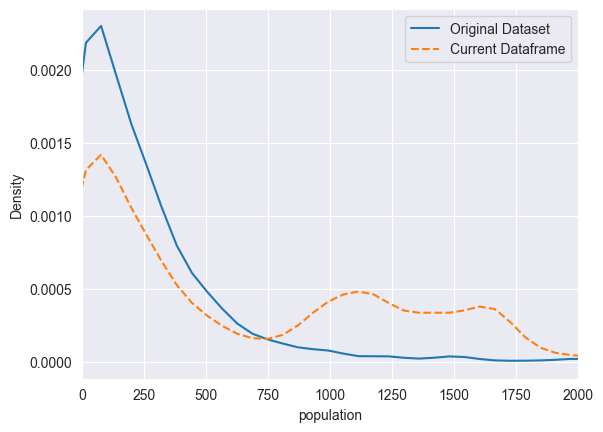

In [96]:
X_train['population'].plot(kind='kde', )
pop_df['population'].plot(kind='kde', style = "--")
labels = ['Original Dataset', 'Current Dataframe']
plt.legend(labels)
plt.xlabel('population')
plt.xlim(0, 2000)
plt.show()

This is not very convincing as the two datasets now have a very different distribution. We are now going to use the MICE as we did for the location

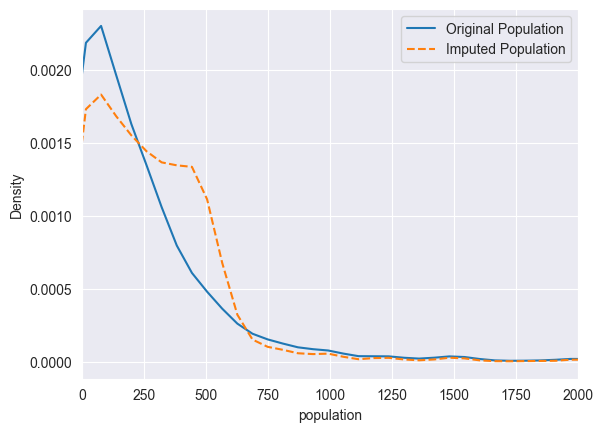

In [97]:
X_train['population'].plot(kind='kde', )
df_train_mice['population'].plot(kind='kde', style = "--")
labels = ['Original Population', 'Imputed Population']
plt.legend(labels)
plt.xlabel('population')
plt.xlim(0, 2000)
plt.show()

X_train['population'] = df_train_mice['population']
X_test['population'] = df_test_mice['population']
test_values['population'] = df_test_values_mice['population']
log_imputation('population', 'mice', final=True)


This is a lot more consistent with the original dataset, therefore we are going to choose the MICE Imputation once again.

### Construction Year

In [98]:
print("Number of null Construction Years: ", X_train['construction_year'].isnull().sum())


Number of null Construction Years:  14451


Intuitively something like getting a mean of the construction year for such a high number of missing values does not seem very safe, therefore we are going to perform a MICE imputation once again from earlier

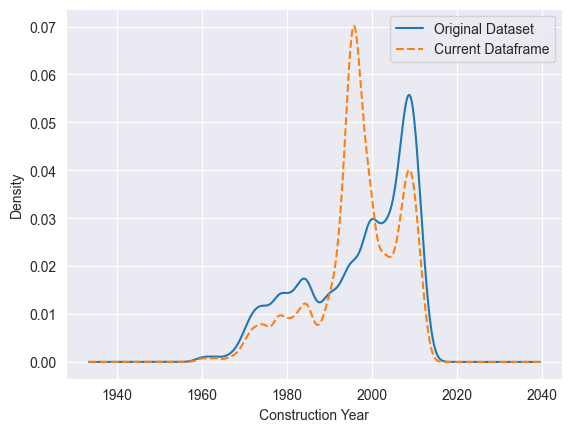

In [99]:

X_train['construction_year'].plot(kind='kde', )
df_train_mice['construction_year'].plot(kind='kde', style = "--")
labels = ['Original Dataset', 'Current Dataframe']
plt.legend(labels)
plt.xlabel('Construction Year')
plt.show()

In [100]:
X_train['construction_year'] = df_train_mice['construction_year']
X_test['construction_year'] = df_test_mice['construction_year']
test_values['construction_year'] = df_test_values_mice['construction_year']
log_imputation('construction_year', 'mice', final=True)


A last change is to use numerical data for our dataframe instead of a timestmap

In [101]:
for df in dataframes:
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    df = df.drop(columns=['date_recorded'])


<hr>

### Data Cleaning / Imputing Progress

In [102]:
#Check on imputation Progress

coursework_progress

,Column Names,Taken Care Of,Imputation Techniques Tried,Imputation Technique Used
0,id,False,[],None
1,amount_tsh,True,[removal],removal
2,date_recorded,False,[],None
3,funder,True,[missing category],missing category
4,gps_height,True,"[mean, mice]",mice
5,installer,True,[missing category],missing category
6,longitude,True,"[mean, mice]",mice
7,latitude,True,"[mean, mice]",mice
8,wpt_name,False,[],None
9,num_private,True,[removal],removal


In [103]:
missing = round((X_train.isna().sum()) / len(df) * 100, 1)
missing = missing.sort_values(ascending=False)
missing.head(15)

subvillage               0.4
permit                   0.0
extraction_type          0.0
extraction_type_group    0.0
extraction_type_class    0.0
management               0.0
management_group         0.0
payment_type             0.0
water_quality            0.0
id                       0.0
quantity_group           0.0
source                   0.0
source_type              0.0
source_class             0.0
waterpoint_type          0.0
dtype: float64

## Encoding Categorical Features as Numeric + SVD

In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

categorical_features = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'extraction_type', 'management', 'payment_type', 'water_quality', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type']
numeric_features = ['gps_height', 'longitude', 'latitude', 'population', 'construction_year', 'year_recorded', 'day_recorded', 'month_recorded']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

svd = TruncatedSVD(n_components=100)  



pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', svd)  # Using SVD instead of PCA
    
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

In [105]:
print("Variance:", svd.explained_variance_ratio_)


Variance: [0.01089931 0.10762415 0.06969988 0.06501123 0.05246844 0.04741349
 0.0420252  0.03958645 0.03274553 0.02499247 0.02426969 0.01974624
 0.01642944 0.01380715 0.01246189 0.01091489 0.01065105 0.00872037
 0.00862698 0.00751778 0.00735927 0.00676699 0.00658142 0.00613934
 0.00605185 0.00573632 0.00539884 0.00506561 0.00481083 0.00468956
 0.00450268 0.00419378 0.003943   0.00369421 0.00348235 0.0032763
 0.00310788 0.00306454 0.00297733 0.00295159 0.00287125 0.00272214
 0.00261984 0.00258145 0.00253596 0.00249648 0.00238456 0.00229896
 0.00220538 0.00213548 0.00202794 0.00195694 0.00192703 0.0018276
 0.00177592 0.00176212 0.00169189 0.00168601 0.00163164 0.00152999
 0.00150013 0.00145491 0.0014017  0.00135855 0.00132954 0.00129558
 0.00129022 0.00124094 0.00121907 0.00119419 0.00115738 0.00114001
 0.00111801 0.00109989 0.00106437 0.00105041 0.00103687 0.00101723
 0.0010115  0.00098301 0.00095935 0.0009553  0.00090862 0.00088489
 0.00087514 0.0008538  0.00082968 0.00081167 0.0008073

# Applying Machine Learning algorithms

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion Matrix display
#Src: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/

def show_confusion_matrix(test, prediction, title):
    labels = test.unique()
    conf_matrix = confusion_matrix(y_test, prediction)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(labels)
    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(labels)
    ax.set_title(title, fontsize=14, pad=20)
    plt.show()

## Classification

### 1] Logistic Regression 

In [107]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Define the logistic regression model
lr = LogisticRegression()

# Define the hyperparameters grid
param_dist = {
    'C': [0.1, 1, 10],  
    'penalty': ['l2'],  
    'solver': ['lbfgs'],  
    'max_iter': [200, 300, 400]
}

# Perform grid search with cross-validation
random_search = RandomizedSearchCV(estimator=lr, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_prepared, y_train)

# Print the best hyperparameters and model score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Model Score:", random_search.best_score_)
("Best Model Score:", random_search.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/matthieu/Coding/pump-it-up/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.1}
Best Model Score: 0.739009139009139


('Best Model Score:', 0.739009139009139)

Logistic Regression Classifier: 
                         precision    recall  f1-score   support

             functional       0.72      0.89      0.80      9678
functional needs repair       0.49      0.09      0.15      1295
         non functional       0.79      0.65      0.71      6847

               accuracy                           0.74     17820
              macro avg       0.67      0.54      0.55     17820
           weighted avg       0.73      0.74      0.72     17820


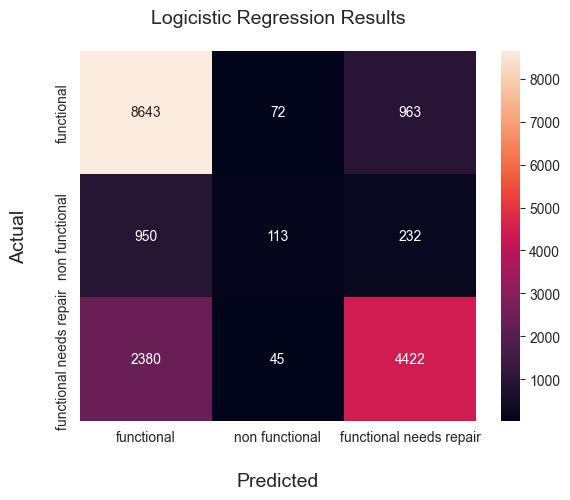

In [108]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000)

lr.fit(X_train_prepared,y_train)

lr_pred= lr.predict(X_test_prepared)

print("Logistic Regression Classifier: ")
print(classification_report(y_test, lr_pred))

show_confusion_matrix(y_test, lr_pred, "Logicistic Regression Results")



### 2] Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()



param_dist = {
    'n_estimators': [400, 500, 600, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_prepared, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Model Score:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/matthieu/Coding/pump-it-up/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matthieu/Coding/pump-it-up/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/matthieu/Coding/pump-it-up/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/matthieu/Coding/pump-it-up/.venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}
Best Model Score: 0.7922799422799423


Random Forest Classifier:
                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      9678
functional needs repair       0.52      0.31      0.38      1295
         non functional       0.82      0.76      0.79      6847

               accuracy                           0.79     17820
              macro avg       0.71      0.65      0.67     17820
           weighted avg       0.78      0.79      0.78     17820


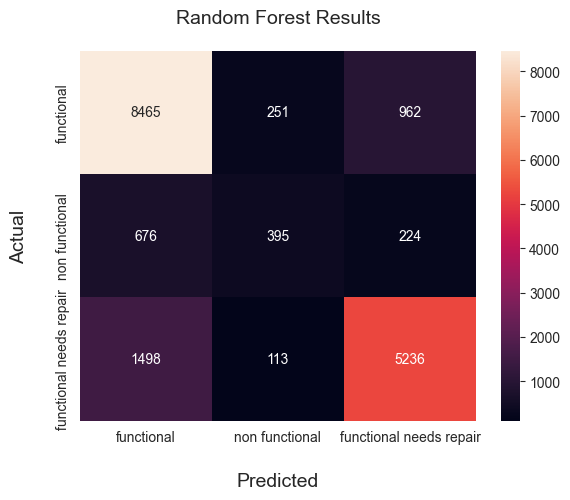

TypeError: 'DataFrame' object is not callable

In [121]:

from sklearn.ensemble import RandomForestClassifier


classifier = RandomForestClassifier()

classifier.fit(X_train_prepared, y_train)

predictions = classifier.predict(X_test_prepared)

print("Random Forest Classifier:")
print(classification_report(y_test, predictions))


show_confusion_matrix(y_test, predictions, "Random Forest Results")
importances = classifier.feature_importances_
features = X_train.columns
feature_importance = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_train_prepared.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_prepared.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


### 3] Support Vector Machine(SVM)

In [111]:
from sklearn.svm import SVC

#Initialize the SVM classifier
svm_classifier = SVC()

#Train the classifier
svm_classifier.fit(X_train_prepared, y_train)

#Make predictions on the test set
svm_pred = svm_classifier.predict(X_test_prepared)

#Evaluate the classifier
print("Support Vector Machine Classifier:")
print(classification_report(y_test, svm_pred))


[CV] END ......C=0.1, max_iter=300, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ........C=1, max_iter=300, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END .......C=10, max_iter=200, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  27.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  50.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.0min
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END ......C=0.1, max_iter=30

### 4] Decision Tree Classifier

[CV] END ......C=0.1, max_iter=200, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ........C=1, max_iter=300, penalty=l2, solver=lbfgs; total time=   1.3s
[CV] END .......C=10, max_iter=300, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  52.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 2.5min
Decision tree classifier: 
                         precision    recall  f1-score   support

             functional       0.78      0.77      0.77      9678
functional needs repair       0.32      0.34      0.33      1295
         non functional       0.73      0.74      0.73      6847

               accuracy                           0.73     17820
              macro avg       0.61      0.6

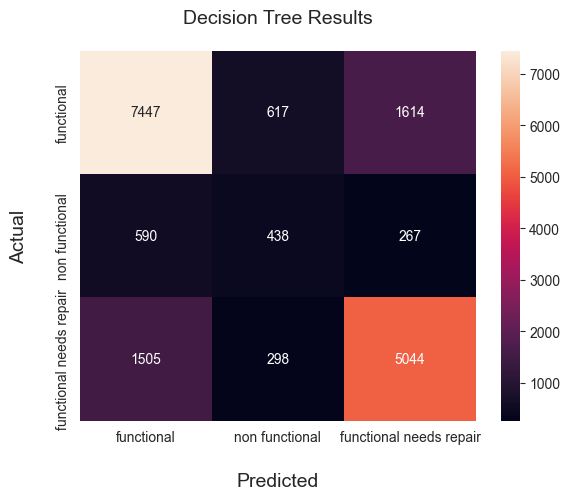

In [112]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_prepared, y_train)
dt_predictions = dt_classifier.predict(X_test_prepared)

print("Decision tree classifier: ")
print(classification_report(y_test, dt_predictions))

show_confusion_matrix(y_test, dt_predictions, "Decision Tree Results")


### 5] Multilayer Perceptron Neural Network (MLP)

/Users/matthieu/Coding/pump-it-up/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Multilayer Perceptron (MLP) Classifier:
                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      9678
functional needs repair       0.50      0.30      0.37      1295
         non functional       0.79      0.77      0.78      6847

               accuracy                           0.78     17820
              macro avg       0.69      0.64      0.66     17820
           weighted avg       0.77      0.78      0.77     17820


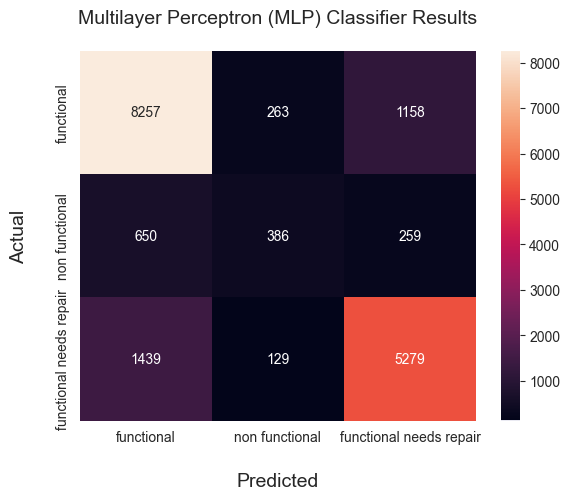

In [113]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=100, activation='relu', solver='adam', random_state=1)

# Train the classifier
mlp_classifier.fit(X_train_prepared, y_train)

# Make predictions on the test set
mlp_pred = mlp_classifier.predict(X_test_prepared)

# Evaluate the classifier
print("Multilayer Perceptron (MLP) Classifier:")
print(classification_report(y_test, mlp_pred))
show_confusion_matrix(y_test, mlp_pred, "Multilayer Perceptron (MLP) Classifier Results")


### 6] K-Nearest Neighbour (KNN)

K-Nearest Neighbors (KNN) Classifier:
                         precision    recall  f1-score   support

             functional       0.78      0.87      0.82      9678
functional needs repair       0.49      0.32      0.39      1295
         non functional       0.81      0.72      0.76      6847

               accuracy                           0.77     17820
              macro avg       0.69      0.64      0.66     17820
           weighted avg       0.77      0.77      0.77     17820


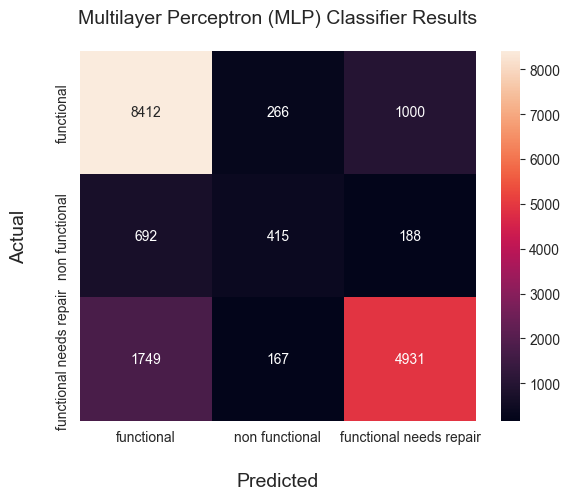

In [114]:
from sklearn.neighbors import KNeighborsClassifier

#Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (K) as needed

#Training the classifier
knn_classifier.fit(X_train_prepared, y_train)

#Make predictions on the test set
knn_pred = knn_classifier.predict(X_test_prepared)

#Evaluate
print("K-Nearest Neighbors (KNN) Classifier:")
print(classification_report(y_test, knn_pred))
show_confusion_matrix(y_test, knn_pred, "Multilayer Perceptron (MLP) Classifier Results")


### 7] Gaussian Naive Bayes 

Gaussian Naive Bayes Classifier:
                         precision    recall  f1-score   support

             functional       0.71      0.73      0.72      9678
functional needs repair       0.27      0.30      0.28      1295
         non functional       0.66      0.63      0.64      6847

               accuracy                           0.66     17820
              macro avg       0.55      0.55      0.55     17820
           weighted avg       0.66      0.66      0.66     17820


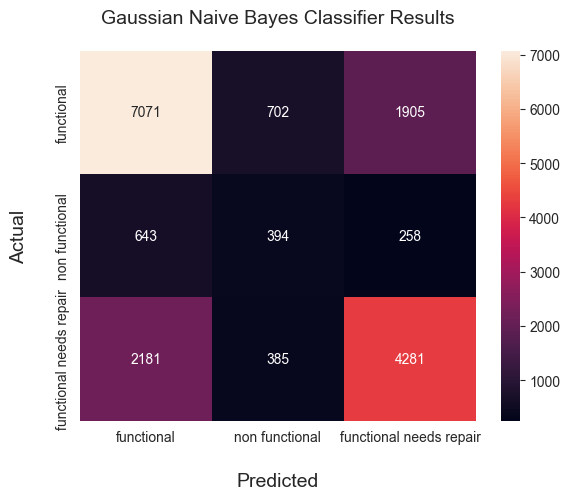

In [115]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Train the classifier
gnb_classifier.fit(X_train_prepared, y_train)

# Make predictions on the test set
gnb_pred = gnb_classifier.predict(X_test_prepared)

# Evaluate the classifier
print("Gaussian Naive Bayes Classifier:")
print(classification_report(y_test, gnb_pred))
show_confusion_matrix(y_test, gnb_pred, "Gaussian Naive Bayes Classifier Results")



### 8] Neural Network

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41580 entries, 30018 to 1323
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     41580 non-null  int64         
 1   date_recorded          41580 non-null  datetime64[ns]
 2   funder                 41580 non-null  object        
 3   gps_height             41580 non-null  float64       
 4   installer              41580 non-null  object        
 5   longitude              41580 non-null  float64       
 6   latitude               41580 non-null  float64       
 7   wpt_name               41578 non-null  object        
 8   basin                  41580 non-null  object        
 9   subvillage             41319 non-null  object        
 10  region                 41580 non-null  object        
 11  region_code            41580 non-null  int64         
 12  district_code          41580 non-null  int64         
 13  lga

In [117]:
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [118]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


y_train_nn = to_categorical(y_train_encoded)
y_test_nn = to_categorical(y_test_encoded)

NameError: name 'y_train_encoded' is not defined

In [ ]:
import os

if not os.environ.get("DEEPNOTE"):
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train_prepared.shape[1]),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # Change to 3 neurons, one for each class
    ])


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train_prepared, y_train_nn, epochs=10, batch_size=32, validation_split=0.1)

    test_loss, test_acc = model.evaluate(X_test_prepared, y_test_nn)
    print("Test accuracy:", test_acc)
else:
    print("This is a deepnote environment. Skipping Neural networks")

## Evaluation Metrics

### K-fold cross validation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa0cdc8d-bec1-43a1-9a51-9c5b6130c78f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>